In [1]:
""" Imports """
import random
import itertools
import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms import bipartite

In [2]:
""" globale Definitionen """
random.seed('Zufall!!')
mapWidth = 500
mapHeight = 250

### Skills
Im Folgenden wird die Klasse _Skills_ implementiert. Sie repräsentiert einen Skill mit definierten Namen. Wird kein Name zur Initialisierung übergeben, wird ein Namen aus der ID (fortlaufende Nummer über alle initialisierten Skills) generiert.
Danach werden beispielhaft vier Skills initialisiert. 

In [3]:
class Skill:
    count = 0
    
    def __init__(self, name=None):
        self._id = Skill.count
        Skill.count += 1
        
        if name is None:
            self.name = "Skill " + str(self._id)
        else:
            self.name = name
            
            
    def __str__(self):
        return self.name

In [4]:
'''
sBaggern = Skill("baggern"); sMauern = Skill("mauern")
sHeben = Skill("heben"); sMischen = Skill("mischen"); 

skills = [sBaggern, sMauern, sHeben, sMischen, ]
print "Skills: " + ", ".join([str(skill) for skill in skills])
'''

Skills: baggern, mauern, heben, mischen


## Skillkapazitäten und Agenten (Baufirma)
### Skillkapazität
Agenten (Baufirmen) bieten Skills nicht einzeln, sondern als Skillkapazität (Klasse `SkillCap`) an, jedoch kann in einer Skillkapazität ein Skill natürlich auch nur einmal vorhanden sein. Die Kosten des Agentens für die Bereitstellung der kompletten Skillkapazität oder eines Teiles werden über eine spezifische Kostenfunktion berechnet. Diese wird bei der Initialisierung der Klasse übergeben und errechnet die Kosten auf Grundlage der Menge des angeforderten Skills und der Entfernung zwischen Agent und Baustelle. Es wird hier also die Kostenfunktion »$kosten(t, n, x, y) :\Leftrightarrow$ Kosten für Agenten $x$ für die Bereitstellungen von $n$ Einheiten des Skils $t$ an die Baustelle $y$« für jede Skillkapazität verwaltet.

Beispielhaft initialisieren wir zwei verschiedenen Skillkapazitäten mit unterschiedlicher Kostenfunktion und lassen uns zwei Preise ermitteln.

In [5]:
class SkillCap:
    count = 0
    
    def __init__(self, skill, capacity, costFunction):
        """ Initialisiere eine Skillkapazität mit Skill, Menge und Kostenfunktion. """
        
        self._id = SkillCap.count
        SkillCap.count += 1
        
        self.skill = skill
        self.capacity = self.actCapacity = capacity
        self.costFunction = costFunction
        self.costF = eval(costFunction)
        
    def __str__(self):
        return str(self.skill) + "(" + str(self.actCapacity) + ")"
    
    
    def costs(self, distance, count):
        """ Kosten für eine Menge der Skillkapazität. """
        
        if  0 < count and count <= self.actCapacity:
            return int(self.costF(count, distance))
        else:
            raise None

In [6]:
'''
sk0 = SkillCap(sBaggern, 10, 'lambda k,d: (k/3+1)*d + 200*k')  # 10 items, 3 items per shipment, one item 200
sk1 = SkillCap(sMauern,   8, 'lambda k,d: (k/3+1)*d + 215*k')  #  8 items, 3 items per shipment, one item 215
print "Skillkapazitäten: " + str(sk0) + ", " + str(sk1)

print "Kosten für 2 Items sk0, Distanz 5: " + str(sk0.costs(5, 2))
print "Kosten für 4 Items sk0, Distanz 5: " + str(sk0.costs(5, 4))
'''

Skillkapazitäten: baggern(10), mauern(8)
Kosten für 2 Items sk0, Distanz 5: 405
Kosten für 4 Items sk0, Distanz 5: 810


### Agent (Baufirma)
Eine Agent (Baufirma, Klasse `Agent`) sitzt in unserem Spiel auf einem bestimmten Punkt im 2D-Raum und hält Skillkapazitäten bereit. Im Laufe des Spiel verkauft er diese an Baustellen. In dieser Klasse wird für den instanziierten Agenten $x$ die Funktion »$supply(x, t) \mapsto n :\Leftrightarrow$ Agent $x$ besitzt $n$ Einheiten vom Skill $t$« verwaltet. Die Kostenfunktion »$kosten(t, n, x, y)$« kann bei dem Agenten für jede seine Skillkapazitäten abgefragt werden.

Im Folgenden wird ein Agenten mit den weiter oben definierten Skillkapazitäten erstellt. Der Agent verkauft danach zwei Einheiten "baggern" an eine Baustelle, die 5 Einheiten entfernt liegt.

In [7]:
class Agent:
    count = 0
    
    def __init__(self, skillCaps, x=None, y=None):
        """ Initialisieren eines Agenten mit übergebenen Skillkapazitäten. Werden keine Koordinaten übergeben, 
            wird der Agent zufällig auf der Karte platziert. """
        
        self._id = "A"+str(Agent.count)
        Agent.count += 1
        
        self.skillCaps = skillCaps
        if x is None: self.x = random.uniform(0, mapWidth)
        else: self.x = x
        if y is None: self.y = random.uniform(0, mapHeight)
        else: self.y = y
    
    def __str__(self):
        skillString = ""
        if len(self.skillCaps) > 0:
            skillString = " (" + ", ".join([str(skillCap) for skillCap in self.skillCaps]) + ")"
        
        return("Agent " + str(self._id) + skillString)
    
    
    @property
    def supply(self):  # Agent, Skill, Menge 
        tmp = [[self._id, str(skillCap.skill), skillCap.capacity] for skillCap in self.skillCaps]
        tmp = np.array(tmp, dtype=object)
        tmp[:,0].astype(str); tmp[:,1].astype(str); tmp[:,2].astype(int);
        return tmp
    
    @property
    def costs(self):  # Agent, Skill, Kostenfunktion
        return np.array([[self._id, str(skillCap.skill), skillCap.costFunction] for skillCap in self.skillCaps])
    
    def getCosts(self, skill, count, distance):
        skillCap = [skillC for skillC in self.skillCaps if str(skillC.skill) == skill]
        if len(skillCap) > 0:
            return int(skillCap[0].costF(distance, count))
        else:
            return None
    
    def checkSell(self, skill, count, price, distance):
        skillCap = [skillC for skillC in self.skillCaps if skillC.skill == skill]
        if len(skillCap) > 0 and 0 < skillCap[0].count and count <= skillCap[0].actCapacity \
         and int(skillCap[0].costF(distance, count)) <= price:
            return True
        else:
            return False
    
    def sell(self, skill, count, distance):      
        skillCap = [skillC for skillC in self.skillCaps if skillC.skill == skill][0]
        skillCap.actCapacity -= count
        return int(skillCap.costF(distance, count))

In [8]:
'''
# Agenten erstellen mit den obigen Skillkapazitäten
agent0 = Agent((sk0, sk1))
print agent0

# Verkauf von 2 Einheiten des Skills "baggern" über die Distanz von 5
print "Agent verkauft 2 Einheiten \"baggern\" über die Distanz 5 mit den Kosten " + \
       str(agent0.sell(sBaggern, 2, 5))
print agent0
'''

Agent A0 (baggern(10), mauern(8))
Agent verkauft 2 Einheiten "baggern" über die Distanz 5 mit den Kosten 1004
Agent A0 (baggern(8), mauern(8))


## Ausschreibungen und Baustellen
### Ausschreibung
In einer Ausschreibung (Klasse `SkillReq`) wird die von einer Baustelle gewünschte Menge eines Skills festgehalten. Beispielhaft erstellen wir zwei Requests.

In [9]:
class SkillReq:
    count = 0
    
    def __init__(self, skill, amount):
        """ Initialisiere einer Ausschreibung mit Skill und Menge. """
    
        self._id = SkillReq.count
        SkillReq.count += 1
        
        self.skill = skill
        self.amount = self.actAmount = amount
    
    
    def __str__(self):
        return str(self.skill) + "(" + str(self.actAmount) + ")"

In [10]:
'''
# Definition zweier Ausschreibungen
req0 = SkillReq(sBaggern, 5)
req1 = SkillReq(sMauern, 5)
print "Requests: " + str(req0) + ", " + str(req1)
'''

Requests: baggern(5), mauern(5)


### Baustelle
Im Laufe des Spiel sind es die Baustellen (Klasse `Site`), deren Ausschreibungen im Rahmen ihres Budgets im Laufe eines Spieles von den Agenten erfüllt werden sollen. Auch sie sind fest im Koordinatensystem einem Ort zugeordnet, der zufällig ist, sollte keiner übergeben werden. Diese Klasse besitzt also die Eigenschaften »$demand(x, t) \mapsto n :\Leftrightarrow$ Baustelle $x$ benötigt $n$ Einheiten vom Skilltyp $t$«, die uns alle Ausschreibungen aggregiert. Das Budget »$budget(x) \mapsto n :\Leftrightarrow$ Baustelle $x$ ist bereit einen Gewinn von maximal $n$ bei Fertigstellung auszuzahlen« ist direkt der Klasse Baustelle zugeordnet.

Beispielhaft wird eine Baustelle mit Budget 2000 erstellt, die fünf Einheiten "baggern" und "mauern" benötigt. Sie kauft im Folgenden 3 Einheiten des Skills "baggern" für 1200.

In [11]:
class Site:
    count = 0
    
    def __init__(self, requests, budget, x=None, y=None):
        """ Initialisiere einer Baustelle mit übergebenen Request. Werden keine Koordinaten übergeben, 
            wird die Baustelle zufällig auf der Karte platziert. """
        
        self._id = "B"+str(Site.count)
        Site.count += 1
        
        self.requests = requests
        self.bud = self.actBudget = budget
        if x is None: self.x = random.uniform(0, mapWidth)
        else: self.x = x
        if y is None: self.y = random.uniform(0, mapHeight)
        else: self.y = y
    
    def __str__(self):
        requestString = ""
        if len(self.requests) > 0:
            requestString = " (" + ", ".join([str(request) for request in self.requests]) + ")"
        
        return("Baustelle " + str(self._id) + " (Budget: " + str(self.actBudget) + ")" + requestString)
    
    @property
    def demand(self):  # Baustelle, Skill, Menge
        tmp = [[self._id, str(request.skill), request.amount] for request in self.requests]
        tmp = np.array(tmp, dtype=object)
        tmp[:,0].astype(str); tmp[:,1].astype(str); tmp[:,2].astype(int);
        return tmp
    
    @property
    def budget(self):  # Baustelle, Budget
        return [self._id, self.bud]
    
    def checkBuy(self, skill, count, price):
        skillReq = [skillR for skillR in self.requests if skillR.skill == skill][0]
        if skillReq is not None and price <= self.actBudget and \
           0 < skillReq.actAmount and count <= skillReq.actAmount:
            return True
        else: 
            return False
    
    def buy(self, skill, count, price):
        skillReq = [skillR for skillR in self.requests if skillR.skill == skill][0]
        skillReq.actAmount -= count
        self.actBudget -= price

In [12]:
'''
# Initialisieren einer Baustelle mit den weiter oben definierten Ausschreibungen
site0 = Site([req0, req1], 2000)
print site0

# Kauf von drei Einheiten Baggern für 1020
site0.buy(sBaggern, 3, 1020)
print "Baustelle kauft drei Einheiten \"baggern\" für 1020 \n" + str(site0)
'''

Baustelle B0 (Budget: 2000) (baggern(5), mauern(5))
Baustelle kauft drei Einheiten "baggern" für 1020 
Baustelle B0 (Budget: 980) (baggern(2), mauern(5))


## Szenario
Ein Szenario (Klasse `Scenario`) bringt nun alle vorherigen Entitäten zu einem Spiel zusammen. Durch eine komplexe Initialisierungs-Methode ist es vielfältig möglich verschiedene Spiele mit unterschiedlichen Skills, Agenten und Baustellen mit Skillkapazitäten, Kostenfunktionen, Skillanforderungen und Budget erstellen. In der Klasse Szenario werden die Funktionen »$match(x,t,y)\mapsto n :\Leftrightarrow$ Agent $x$ sendet $n$ Einheiten des Skilltyps $t$ an die Baustelle $y$« und »$v(x,y)\mapsto n :\Leftrightarrow$ Agent $x$ erhält von Baustelle $y$ die Vergütung $n$« verwaltet. Daneben lassen sich alle Informationen aus der algebraischen Beschreibung des Coalition Skill Games abfragen und z.T. grafisch aufgearbeitet darstellen.

In [13]:
class Scenario:
    
    
    def __init__(self, agentCount=2, siteCount=2, skills=[Skill("mauern"), Skill("baggern")], \
                 skillCap=[[10,20],[15,10]], skillReq=[[7,15],[8,8]], budget=[9000000], \
                 costFunction=[['lambda k,d:(k/5+1)*d+200*k', 'lambda k,d:(k/3+1)*d+250*k']], \
                 agents=None, sites=None):
        """ Initialisierung eines Szenarios: Ohne die weitere Angabe von Parametern wird ein Szenario mit zwei Agenten 
            und einer Baustelle erstellt, die zwei Skills ("mauern" und "baggern") in der Menge (10,20) für Agent 1 
            und (15,10) für Agent 2 als Skillkapazität besitzen bzw. Baustelle 1 (7,15) und Baustelle 2 (8,8) suchen.
            Es gibt für die Skillkapazitäten Standardkostenfunktionen, die z.B. für den ersten Skill von Kosten von 
            200 per item und Shipmentkosten von $distance je 5 items ausgeht. Von dem dritten Skill könne nur 3 auf 
            einmal transportiert werden und eine Einheit kostet 250. Das Defaultbudget der Baustellen beträgt 100.000. 
            
            Alternativ hätte auch für jeden Agenten eine eigene Kostenfunktion bzw. jede Baustelle ein eigenes Budget 
            definiert werden können. Wenn Baustellen und Agenten bereits der Funktion übergeben werden (als Iterable),
            so werden diese benutzt. """
        
        self.skills = skills
        self.sales  = None
        
        # Are there complete sites? ############
        if sites is not None:
            self.sites = sites
        else:
            # check if budget sitewise or for all sites?
            if len(budget) == 1:
                budget = budget * siteCount
            elif len(budget) != siteCount:
                raise Exception("Scenario", "__init__()", "site-budget")
            
            # check skill requests
            if len(skillReq) == 1:
                skillReq = skillReq * siteCount
            elif len(skillReq) != siteCount:
                raise Exception("Scenario", "__init__()", "site-requests")
                
            # create sites
            self.sites = list()
            for site in range(siteCount):
                
                # create Skill Requests
                sk = list()
                if len(skillReq[site]) == len(skills):
                    for i, skill in enumerate(skills):
                        sk.append(SkillReq(skill, skillReq[site][i]))
                elif len(skillReq) != siteCount:
                    raise Exception("Scenario", "__init__()", "site-requests-creation")

                self.sites.append(Site(sk, budget[site]))
        
        # Are there complete agents? ############
        if agents is not None:
            self.agents = agents
        else:
            # check if costFunction sitewise or for all sites?
            if len(costFunction) == 1:
                costFunction = costFunction * agentCount
            elif len(costFunction) != agentCount:
                raise Exception("Scenario", "__init__()", "agent-costFunction")
            
            # check skill capacities
            if len(skillCap) == 1:
                skillCap = skillCap * agentCount
            elif len(skillCap) != agentCount:
                raise Exception("Scenario", "__init__()", "agent-capabilities")
                
            # create agents
            self.agents = list()
            for agent in range(agentCount):
                
                # create Skill Capacities
                sk = list()
                if len(skillCap[agent]) == len(skills):
                    for i, skill in enumerate(skills):
                        sk.append(SkillCap(skill, skillCap[agent][i], costFunction[agent][i]))
                elif len(skillReq) != siteCount:
                    raise Exception("Scenario", "__init__()", "agent-cap-creation")
                    
                self.agents.append(Agent(sk))
     
        
    def __str__(self):
        """ Ausgabe des Szenarios in der definierten Algebra-Schreibweise. """
        supply  = [ ", ".join([elem[0], elem[1], str(elem[2])]) for elem in self.supply]
        demand  = [ ", ".join([elem[0], elem[1], str(elem[2])]) for elem in self.demand]
        budget  = [ ", ".join([elem[0], elem[1]]) for elem in list(self.budget)]
        costs   = [ ", ".join([elem[0], elem[1], elem[2]]) for elem in list(self.costs)]
        matches = [ ", ".join([elem[0], elem[1], elem[2], elem[3], elem[4]]) for elem in list(self.matches)]
        
        return "Agenten: " + ", ".join(self.agent) + "\nBaustellen: " + ", ".join(self.site) + "\n" + \
               "Supply: " +  "("+"), (".join(supply)+")" + "\nDemand: " +"("+"), (".join(demand)+")\n" + \
               "Budget: " + "("+"), (".join(budget)+")" + "\nCosts: " +"("+"), (".join(costs)+")\n" + \
               "Matches: "+ "("+"), (".join(matches)+")" 
    
    
    @property
    def agent(self):   # Agent
        return np.array([agent._id for agent in self.agents])
    
    @property
    def site(self):    # Baustelle
        return np.array([site._id for site in self.sites])
                                           
    @property
    def supply(self):  # Agent, Skill, Menge
        return np.concatenate([agent.supply for agent in self.agents], axis=0)
    
    @property
    def demand(self):  # Baustelle, Skill, Menge
        return np.concatenate([site.demand for site in self.sites], axis=0)
    
    @property
    def budget(self):  # Baustelle, Budget
        return np.array([site.budget for site in self.sites])
    
    @property
    def costs(self):   # Agent, Skill, Kostenfunktion
        return np.concatenate([agent.costs for agent in self.agents])
    
    @property
    def matches(self): # Agent, Baustelle, Skill, Menge, Preis
        return self.sales[0:5] if self.sales is not None else list()
    
    
    def match(self, agent, site, skill, amount, price):
        """ Über diese Funktion wird ein Verkaufsvorgang durchgeführt bzw. ein Matching eingetragen. 
            Dieser Vorgang wird beschrieben durch den verkaufenden Agente, der kaufenden Baustelle, 
            den verhandelten Skill und den von der Baustelle bezahlten Preis. Wir speichern zusätzlich
            die Kosten für den Agenten. """
        
        # Kriegen wir Objekte oder IDs?
        if isinstance(agent, basestring): 
            agent = [elem for elem in self.agents if elem._id == agent][0]
        if isinstance(site, basestring): 
            site = [elem for elem in self.sites if elem._id == site][0]
        if isinstance(skill, basestring): 
            skill = [elem for elem in self.skills if str(elem) == skill][0]
        

        if agent.checkSell(skill, amount, price, self.distance(agent, site)) \
           and site.checkBuy(skill, amount, price):
                
            costs = agent.sell(skill, amount, self.distance(agent, site))
            site.buy(skill, amount, price)
            
            sale = np.array([[agent._id, site._id, str(skill), str(amount), price, costs]])
            
            if self.sales is None:
                self.sales = sale
            else: 
                self.sales = np.vstack([self.sales, sale])
            return True
        
        else:  # Skill nicht mehr vorhanden bei Site
            return None

        
    def distance(self, a, b):
        return ( ((a.x-b.x)**2)+((a.y-b.y)**2) )**0.5
    
    
    def plotBiGraph(self):
        # create nx-Graph
        B = nx.Graph()
        B.add_nodes_from([agent._id for agent in self.agents], bipartite=0)
        B.add_nodes_from([site._id for site in self.sites], bipartite=1)
        if self.sales is not None:
            B.add_edges_from([(match[0], match[1]) for match in self.sales])
        
        # left or right?
        pos = dict()
        pos.update( (agent._id, (1, i)) for i, agent in enumerate(self.agents) )
        pos.update( (site._id, (2, i)) for i, site in enumerate(self.sites) )
        
        # formating for plotting
        color  = ['b'] * len(self.agents)
        color += ['g'] * len(self.sites)
        
        # labels for edges
        edgeLabels = dict()
        if self.sales is not None:
            labels = [ ((match[0], match[1]), "<- Preis: "+str(match[4])+ \
                " / Skill: "+str(match[2])+"("+str(match[3])+") ->") \
                for match in self.sales]
            
            for label in labels:
                if label[0] not in edgeLabels:
                    edgeLabels[label[0]] = label[1]
                else:
                    edgeLabels[label[0]] = edgeLabels[label[0]]+"\n"+label[1]
        
        # draw it
        nx.draw_networkx_edge_labels(B, pos=pos, edge_labels=edgeLabels)
        nx.draw_networkx(B, pos=pos, with_labels=True, node_size=700, node_color=color)
        plt.axis('off')
        plt.show()
        
        
    def plotMap(self):
        # data
        agent = np.array([[agent.x, agent.y, agent._id, str(agent), 'b'] for agent in self.agents])
        site = np.array([[site.x, site.y, site._id, str(site), 'g'] for site in self.sites])
        plot = np.vstack([agent, site])
        
        # Plot
        fig = plt.figure(1, figsize=(8,5))
        ax = plt.subplot(111)
        
        for i in range(len(plot)):
            ax.scatter(plot[i,0], plot[i,1], s=150, marker="8", label=plot[i,3], c=plot[i,4])
        
        for i, txt in enumerate(plot[:,2]):
            ax.annotate(txt, (plot[i,0], plot[i,1]), xytext=(float(plot[i,0])+10, float(plot[i,1])-5))
        
        ax.set_xticks(np.arange(0,mapWidth,50))
        ax.set_yticks(np.arange(0,mapHeight,25))

        plt.xlim(0, mapWidth)
        plt.ylim(0, mapHeight)
        plt.grid()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
    
    def getStats(self):
        stats = dict()
        
        # Umsatz
        if self.sales is not None:
            print self.sales[:,4]
            stats.update({"Umsatz": sum(self.sales[:,4].astype(int))})
        else:
            stats.update({"Umsatz": 0})
            
        # Kosten
        if self.sales is not None:
            print self.sales
            stats.update({"Kosten": sum(self.sales[:,5].astype(int))})
        else:
            stats.update({"Kosten": 0})
            
        # Gewinn
        stats.update({"Gewinn": stats["Umsatz"] - stats["Kosten"]})
        
        # Requests
        stats.update({"Requests": sum([req.amount for site in self.sites \
                                       for req in site.requests]) })
        
        # Requests offen
        stats.update({"Requests offen": sum([req.actAmount for site in self.sites \
                                            for req in site.requests]) })
        
        # Baustellen
        stats.update({"Baustellen": len(self.sites) })
        
        # Baustellen offen
        stats.update({"Baustellen offen": sum([1 for site in self.sites \
                     if sum([req.actAmount for req in site.requests]) > 0]) })
        
        return stats

### Beispiel Szenario
Wir erstellen ein Standardszenario und lassen uns die schriftliche Beschreibung und die Übersichtskarte ausgeben. Danach ergänzen wir das Szenario um zwei Matches und lassen und das Ergbenis in Form eines bipartiten Graphens ausgeben.

Agenten: A1, A2
Baustellen: B1, B2
Supply: (A1, mauern, 10), (A1, baggern, 20), (A2, mauern, 15), (A2, baggern, 10)
Demand: (B1, mauern, 7), (B1, baggern, 15), (B2, mauern, 8), (B2, baggern, 8)
Budget: (B1, 9000000), (B2, 9000000)
Costs: (A1, mauern, lambda k,d:(k/5+1)*d+200*k), (A1, baggern, lambda k,d:(k/3+1)*d+250*k), (A2, mauern, lambda k,d:(k/5+1)*d+200*k), (A2, baggern, lambda k,d:(k/3+1)*d+250*k)
Matches: ()


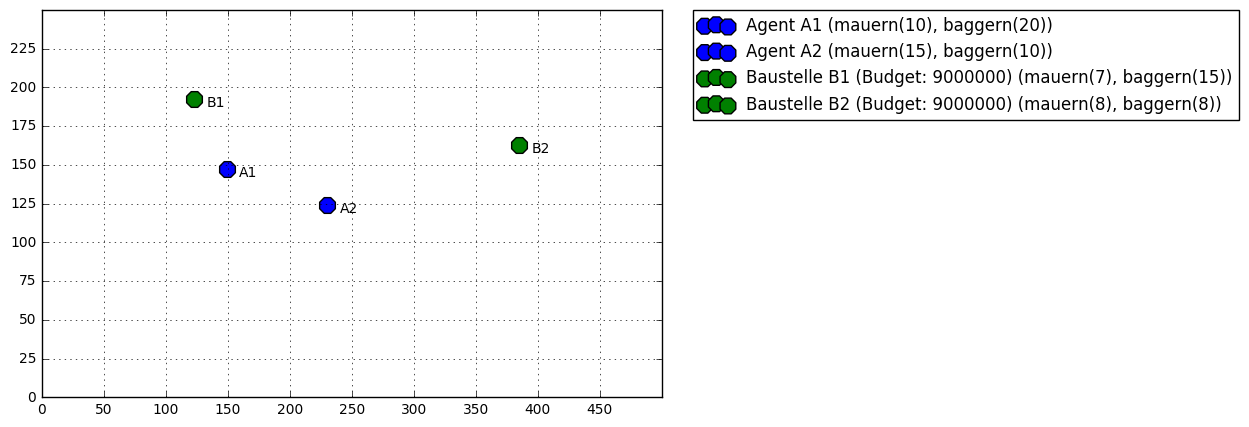

{'Kosten': 0, 'Umsatz': 0, 'Gewinn': 0, 'Requests': 38, 'Baustellen': 2, 'Requests offen': 38, 'Baustellen offen': 2}


In [14]:
'''
scenario = Scenario()
print scenario
scenario.plotMap()
print scenario.getStats()
'''

Agenten: A1, A2
Baustellen: B1, B2
Supply: (A1, mauern, 10), (A1, baggern, 20), (A2, mauern, 15), (A2, baggern, 10)
Demand: (B1, mauern, 7), (B1, baggern, 15), (B2, mauern, 8), (B2, baggern, 8)
Budget: (B1, 9000000), (B2, 9000000)
Costs: (A1, mauern, lambda k,d:(k/5+1)*d+200*k), (A1, baggern, lambda k,d:(k/3+1)*d+250*k), (A2, mauern, lambda k,d:(k/5+1)*d+200*k), (A2, baggern, lambda k,d:(k/3+1)*d+250*k)
Matches: (A1, B1, baggern, 5, 200000), (A1, B1, mauern, 2, 50000), (A1, B2, mauern, 3, 100000)


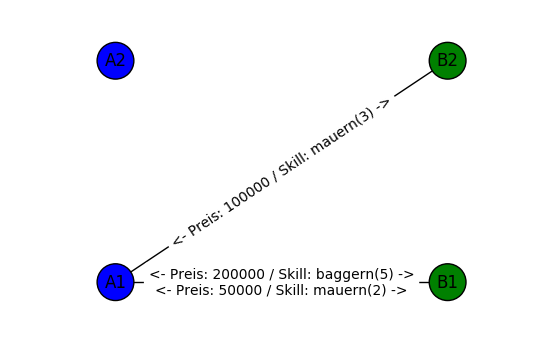

['200000' '50000' '100000']
[['A1' 'B1' 'baggern' '5' '200000' '13216']
 ['A1' 'B1' 'mauern' '2' '50000' '10522']
 ['A1' 'B2' 'mauern' '3' '100000' '47395']]
{'Kosten': 71133, 'Umsatz': 350000, 'Gewinn': 278867, 'Requests': 38, 'Baustellen': 2, 'Requests offen': 28, 'Baustellen offen': 2}


In [15]:
'''
scenario.match(scenario.agents[0], scenario.sites[0], 'baggern', 5, 200000)
scenario.match(scenario.agents[0], scenario.sites[0], 'mauern', 2, 50000)
scenario.match(scenario.agents[0], scenario.sites[1], 'mauern', 3, 100000)
print scenario
scenario.plotBiGraph()
print scenario.getStats()
'''

## Szenariengenerator

In [16]:
def generateScenaries(agentsNumber=2, sitesNumber=3, skillsNumber=2, \
                      capacitiesNumber=(5,6,5), requestsNumber=(5,6)):
    
    # Wir arbeiten mit einem fest definierten Budget und Kostenfunktion 
    # für alle Baustellen und Baufirmen
    budget = 500000
    costF  = 'lambda k,d: (k/3+1)*d + 215*k'  
    
    # Erstellen der notwendigen Anzahl an Skills
    skills = [Skill("Skill " + str(skill)) for skill in range(skillsNumber)]
    
    # Skillkapazitäten und -requests in jeder vorgegebenen Anzahl
    skillCaps = [SkillCap(skill, cn, costF) for cn in capacitiesNumber \
                                            for skill in skills]
    skillReqs = [SkillReq(skill, rn) for rn in requestsNumber \
                                     for skill in skills]
    
    # mögliche Kombinationen aus gegebenen Kapazitäten und Request
    # Dabei werden ignoriert: 1. leere Kapazitäten/Requests
    #                         2. nur Kombinationen gleicher 
    #                            Skills
    scenarieCaps = list()
    for length in range(1, skillsNumber+1):
        for subset in itertools.combinations(skillCaps, length):
            
            # nur Skillkapazitäten eines Skills
            skillId = [elem.skill for elem in subset]
            subsetDict = {x:skillId.count(x) for x in skillId}
            if not any(val > 1 for val in subsetDict.values()):
                scenarieCaps.append(subset)
  
    scenarieReqs = list()
    for length in range(1, skillsNumber+1):
        for subset in itertools.combinations(skillReqs, length):
            
            skillId = [elem.skill for elem in subset]
            subsetDict = {x:skillId.count(x) for x in skillId}
            if not any(val > 1 for val in subsetDict.values()):
                scenarieReqs.append(subset)
            
            
    # Koordinaten für die Agenten und Baustellen sind immer gleich
    coordsAgent = [(random.uniform(0, mapWidth), random.uniform(0, mapHeight)) \
                   for an in range(agentsNumber)]
    coordsSite  = [(random.uniform(0, mapWidth), random.uniform(0, mapHeight)) \
                   for sn in range(sitesNumber)]
     
    # erstellen der Agenten / Skillkapazitäten Kombinationen
    agents = list()
    for scAgents in itertools.product(scenarieCaps, repeat=agentsNumber):
        agentsSc = list()
        for an, cap in enumerate(scAgents):
            agentsSc.append( Agent(cap, coordsAgent[an][0], coordsAgent[an][1]) )
            
        agents.append(agentsSc)
    
    # erstellen der Baustellen / Skillrequest Kombinationen
    sites = list()
    for scSites in itertools.product(scenarieReqs, repeat=sitesNumber):
        sitesSc = list()
        for sn, req in enumerate(scSites):
            sitesSc.append( Site(req, budget, coordsSite[sn][0], coordsSite[sn][1]) )
            
        sites.append(sitesSc)
    
    # Szenarien erstellen
    scenaries = list()
    for sc in itertools.product(agents, sites):
        scenaries.append(Scenario(agents=sc[0], sites=sc[1]))
              
    return scenaries